In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import csv
import seaborn as sns
sns.set(style='whitegrid')
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['figure.dpi'] = 200
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot


C:\Users\ADMIN\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
C:\Users\ADMIN\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Scraping

In [2]:
# Fetch historical data using yfinance
def get_oil_prices(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

In [3]:
symbol = "CL=F"  # Symbol for Crude Oil (Futures)
start_date = "2001-01-01"
end_date = "2024-02-01"

oil_prices_data = get_oil_prices(symbol, start_date, end_date)
oil_prices_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,27.250000,27.400000,26.600000,27.200001,27.200001,52321
2001-01-03,27.230000,28.139999,27.049999,27.950001,27.950001,66628
2001-01-04,28.200001,28.780001,27.850000,28.200001,28.200001,74383
2001-01-05,28.150000,28.799999,27.799999,28.000000,28.000000,63852
2001-01-08,28.200001,28.400000,27.150000,27.350000,27.350000,76058
...,...,...,...,...,...,...
2024-01-25,75.300003,77.510002,75.160004,77.360001,77.360001,320177
2024-01-26,77.150002,78.260002,76.059998,78.010002,78.010002,365456
2024-01-29,78.900002,79.290001,76.410004,76.779999,76.779999,331925


In [4]:
if not oil_prices_data.empty:
    filename = "F:/New folder/oil_prices.csv"
    oil_prices_data.to_csv(filename, index=True)
    print(f"Data saved to '{filename}' successfully.")
else:
    print("Failed to fetch data.")

Data saved to 'F:/New folder/oil_prices.csv' successfully.


## Data Exploration and Preprocessing

In [5]:
df=pd.read_csv('F:/New folder/oil_prices.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,27.250000,27.400000,26.600000,27.200001,27.200001,52321
1,2001-01-03,27.230000,28.139999,27.049999,27.950001,27.950001,66628
2,2001-01-04,28.200001,28.780001,27.850000,28.200001,28.200001,74383
3,2001-01-05,28.150000,28.799999,27.799999,28.000000,28.000000,63852
4,2001-01-08,28.200001,28.400000,27.150000,27.350000,27.350000,76058
...,...,...,...,...,...,...,...
5791,2024-01-25,75.300003,77.510002,75.160004,77.360001,77.360001,320177
5792,2024-01-26,77.150002,78.260002,76.059998,78.010002,78.010002,365456
5793,2024-01-29,78.900002,79.290001,76.410004,76.779999,76.779999,331925
5794,2024-01-30,77.019997,78.139999,75.849998,77.820000,77.820000,347242


In [6]:
#Selecting Required Columns
oil=df[['Date','Adj Close']]


In [7]:
oil

,Date,Adj Close
0,2001-01-02,27.200001
1,2001-01-03,27.950001
2,2001-01-04,28.200001
3,2001-01-05,28.000000
4,2001-01-08,27.350000
...,...,...
5791,2024-01-25,77.360001
5792,2024-01-26,78.010002
5793,2024-01-29,76.779999
5794,2024-01-30,77.820000


In [8]:
# Renaming The Column
oil.rename(columns={"Adj Close":"Price"},inplace=True)

In [9]:
# Change the index of the oil as Date index
oil.set_index('Date', inplace=True)

In [10]:
oil.head()

,Price
Date,
2001-01-02,27.200001
2001-01-03,27.950001
2001-01-04,28.200001
2001-01-05,28.000000
2001-01-08,27.350000


In [11]:
oil.index = pd.to_datetime(oil.index)

In [12]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5796 entries, 2001-01-02 to 2024-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5796 non-null   float64
dtypes: float64(1)
memory usage: 90.6 KB


In [13]:
oil.isnull().sum()

Price    0
dtype: int64

In [14]:
oil.dtypes

Price    float64
dtype: object

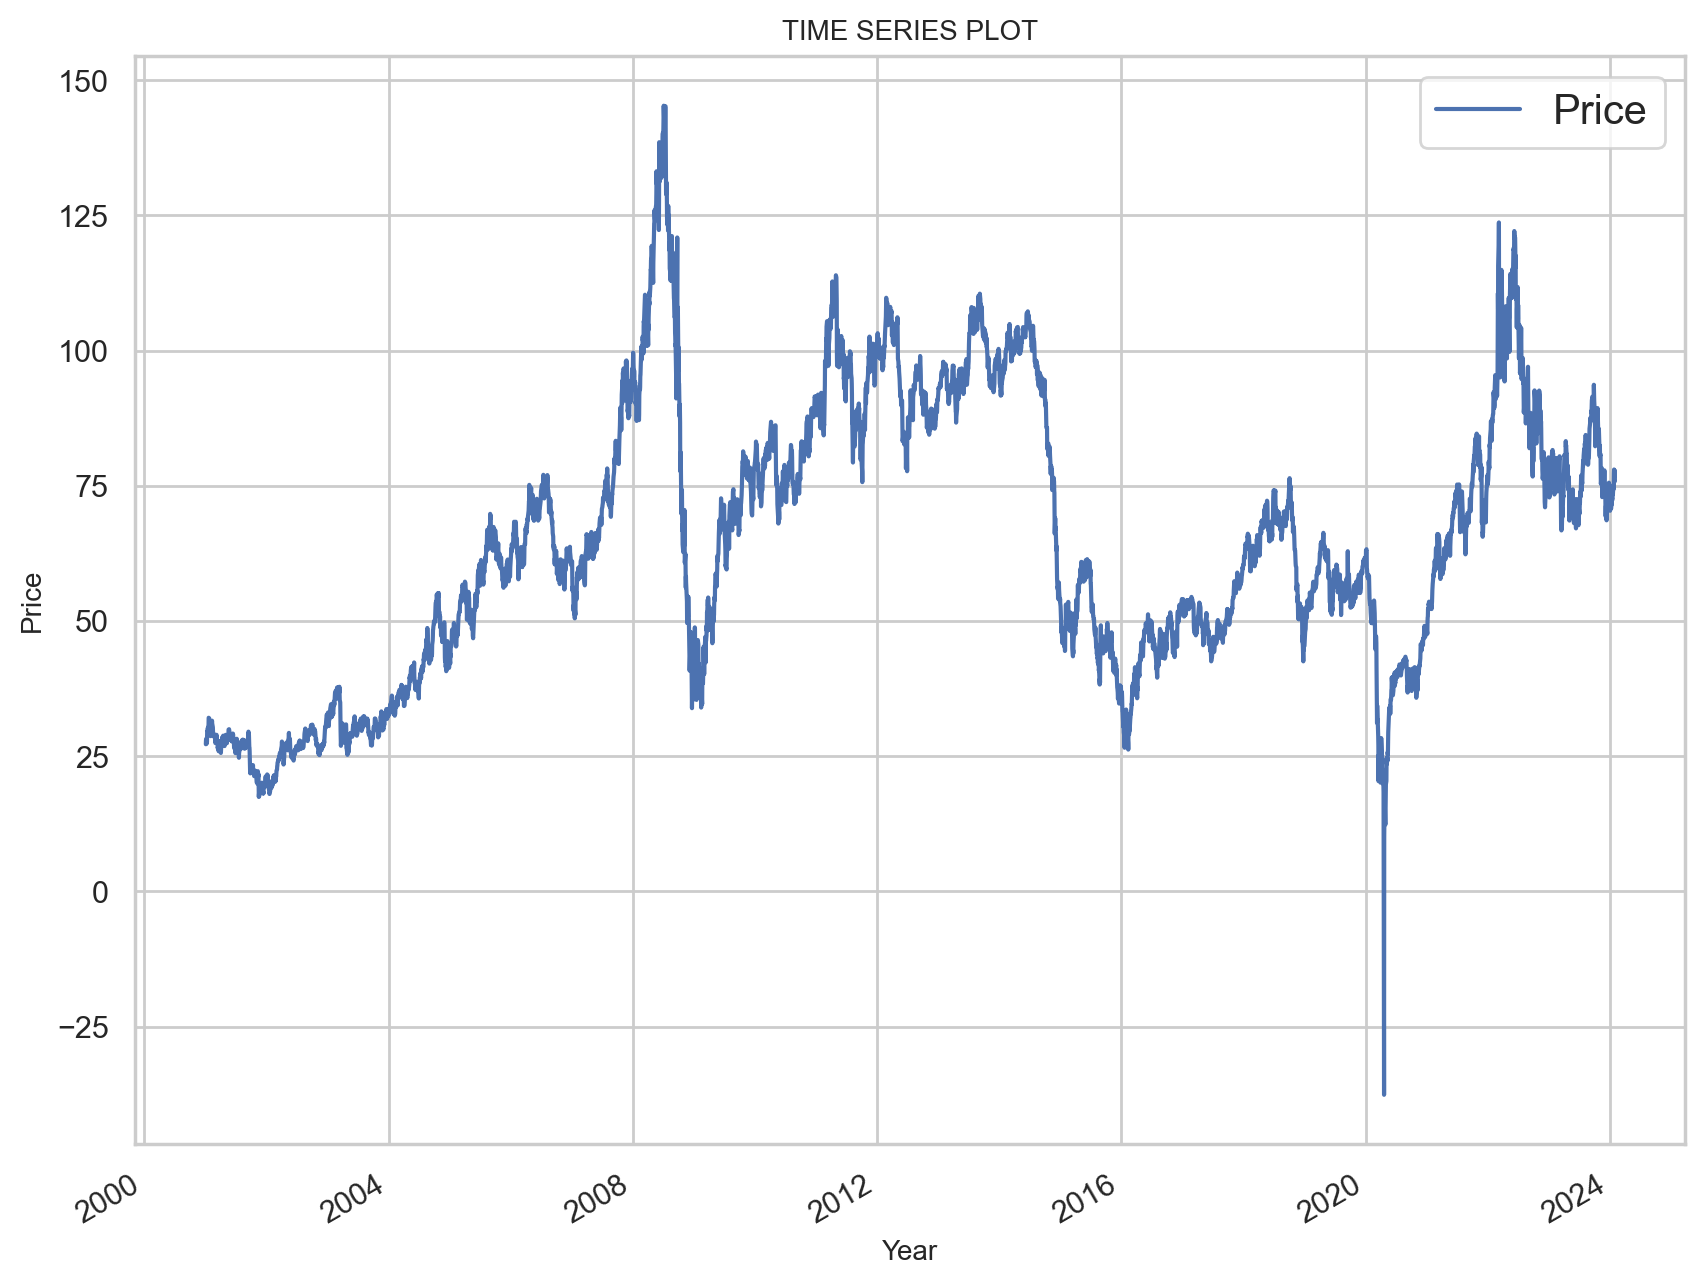

In [15]:
# Time Series Plot of oil price over the Years
oil.plot(grid=True)
plt.legend(fontsize=15)
plt.title("TIME SERIES PLOT",fontsize=10)
plt.xlabel("Year", fontsize=10)
plt.ylabel("Price",fontsize=10)
plt.savefig('TimeSeries.png')

(0.0, 150.0)

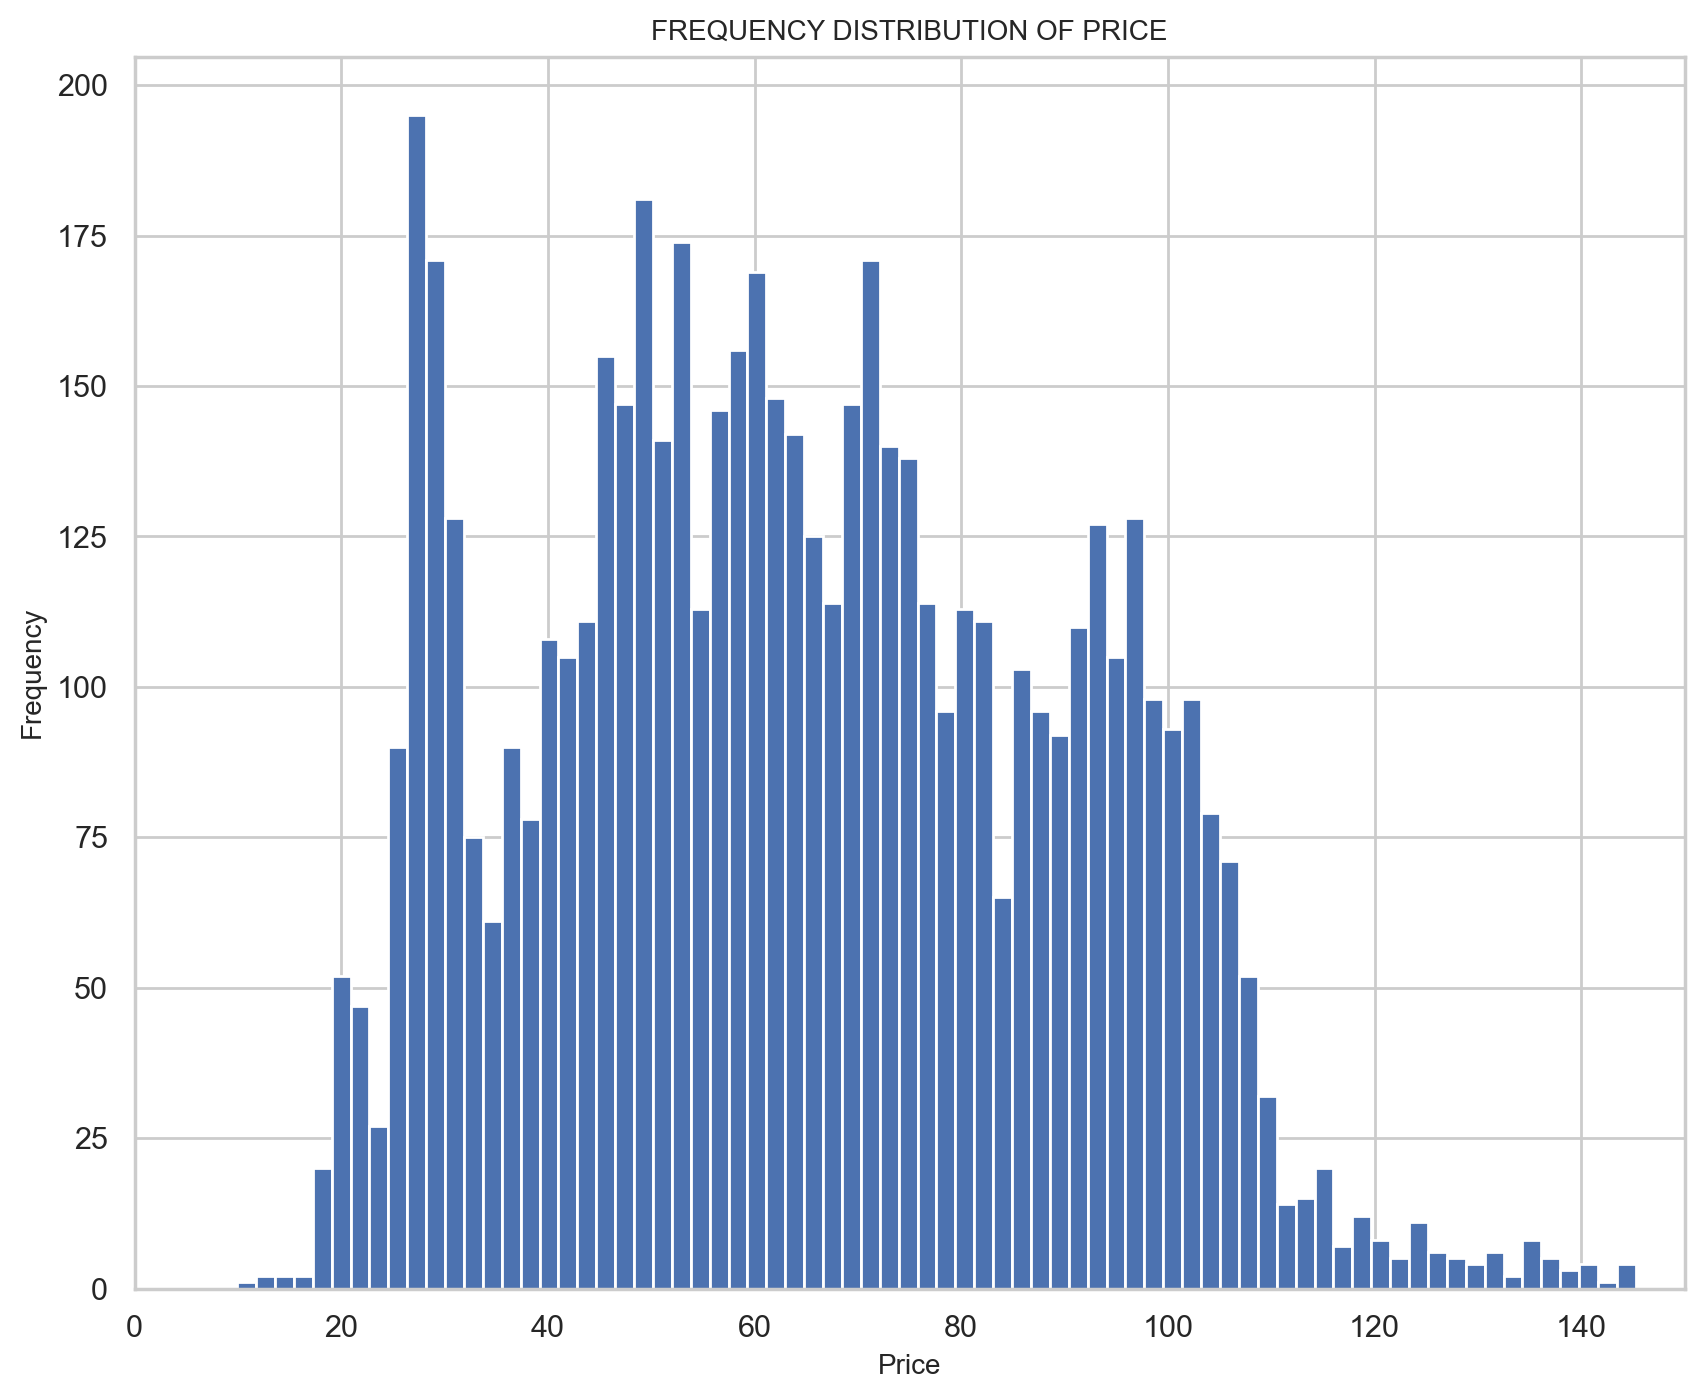

In [16]:
plt.hist(oil['Price'],bins=100)
plt.title("FREQUENCY DISTRIBUTION OF PRICE",fontsize=10)
plt.xlabel("Price", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xlim([0,150])

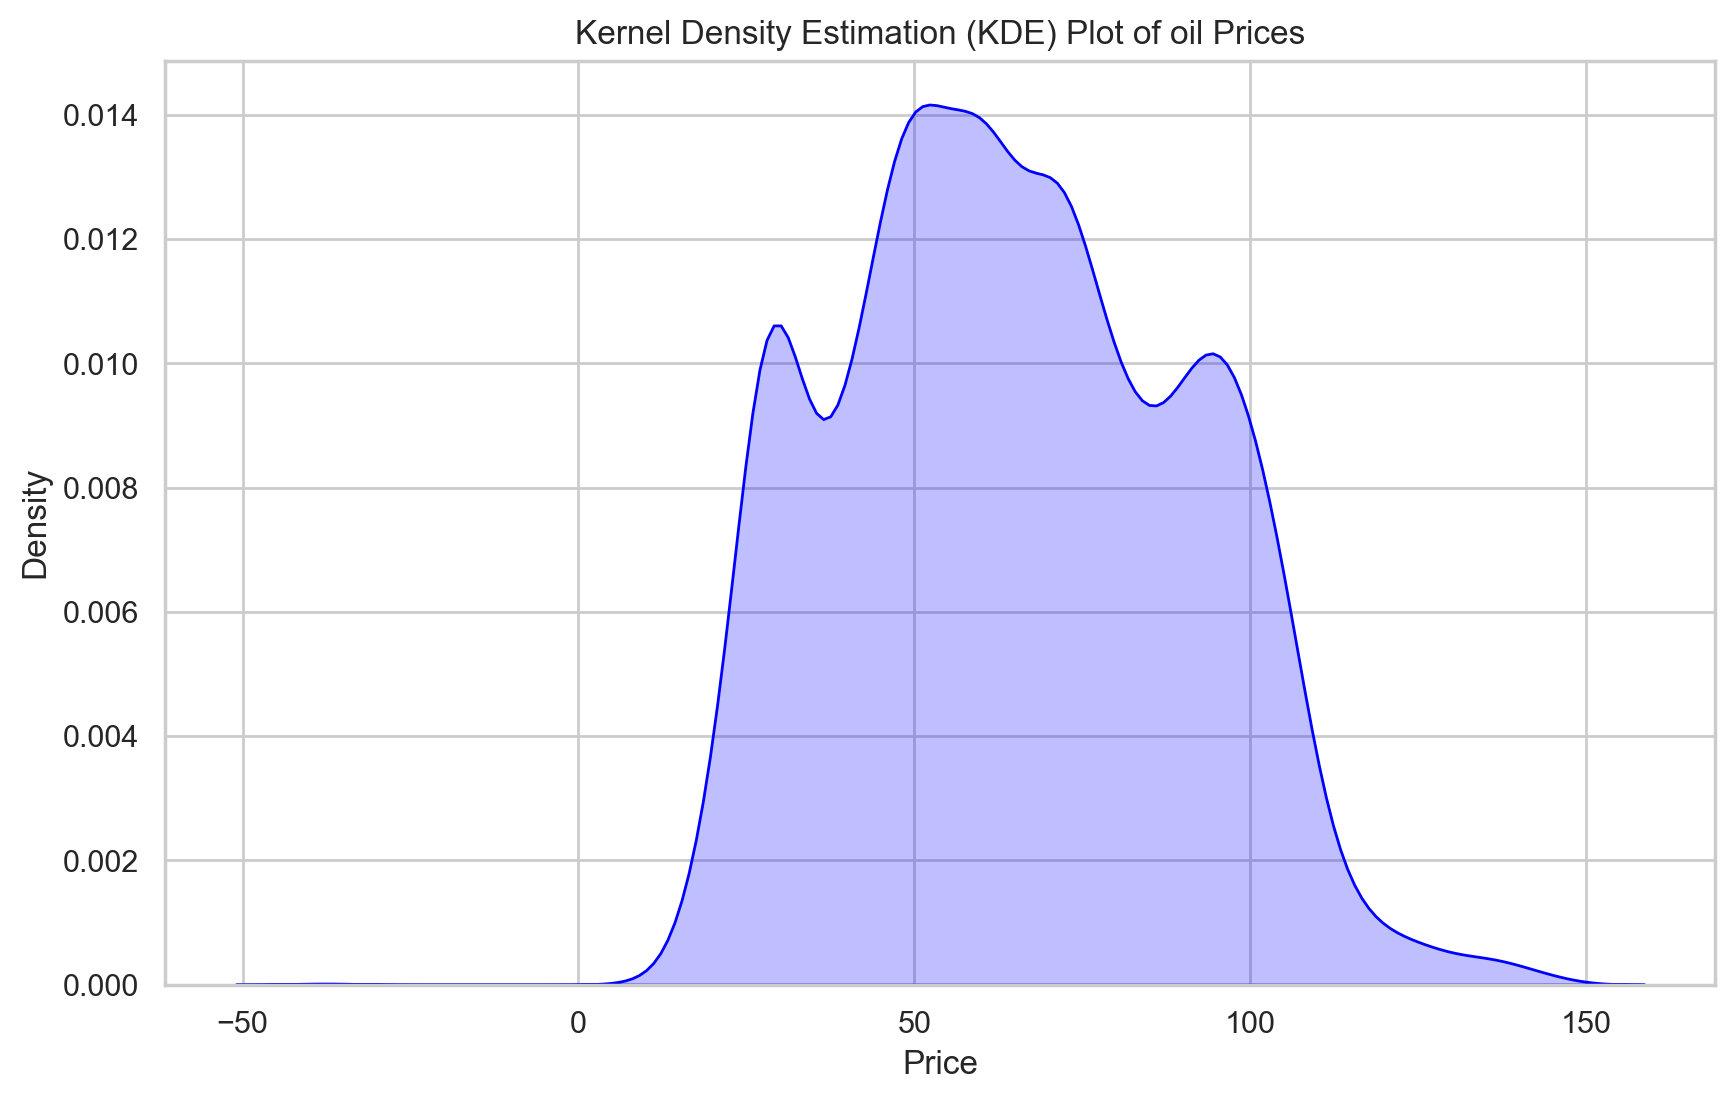

In [17]:
# Kernel density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(oil['Price'], color='blue', fill=True)
plt.title('Kernel Density Estimation (KDE) Plot of oil Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.savefig('Density_plot.png')

In [18]:
# Daily Percentage Change
pct_change=oil[['Price']].pct_change()
pct_change

,Price
Date,
2001-01-02,NaN
2001-01-03,0.027574
2001-01-04,0.008945
2001-01-05,-0.007092
2001-01-08,-0.023214
...,...
2024-01-25,0.030230
2024-01-26,0.008402
2024-01-29,-0.015767


(-0.3, 0.3)

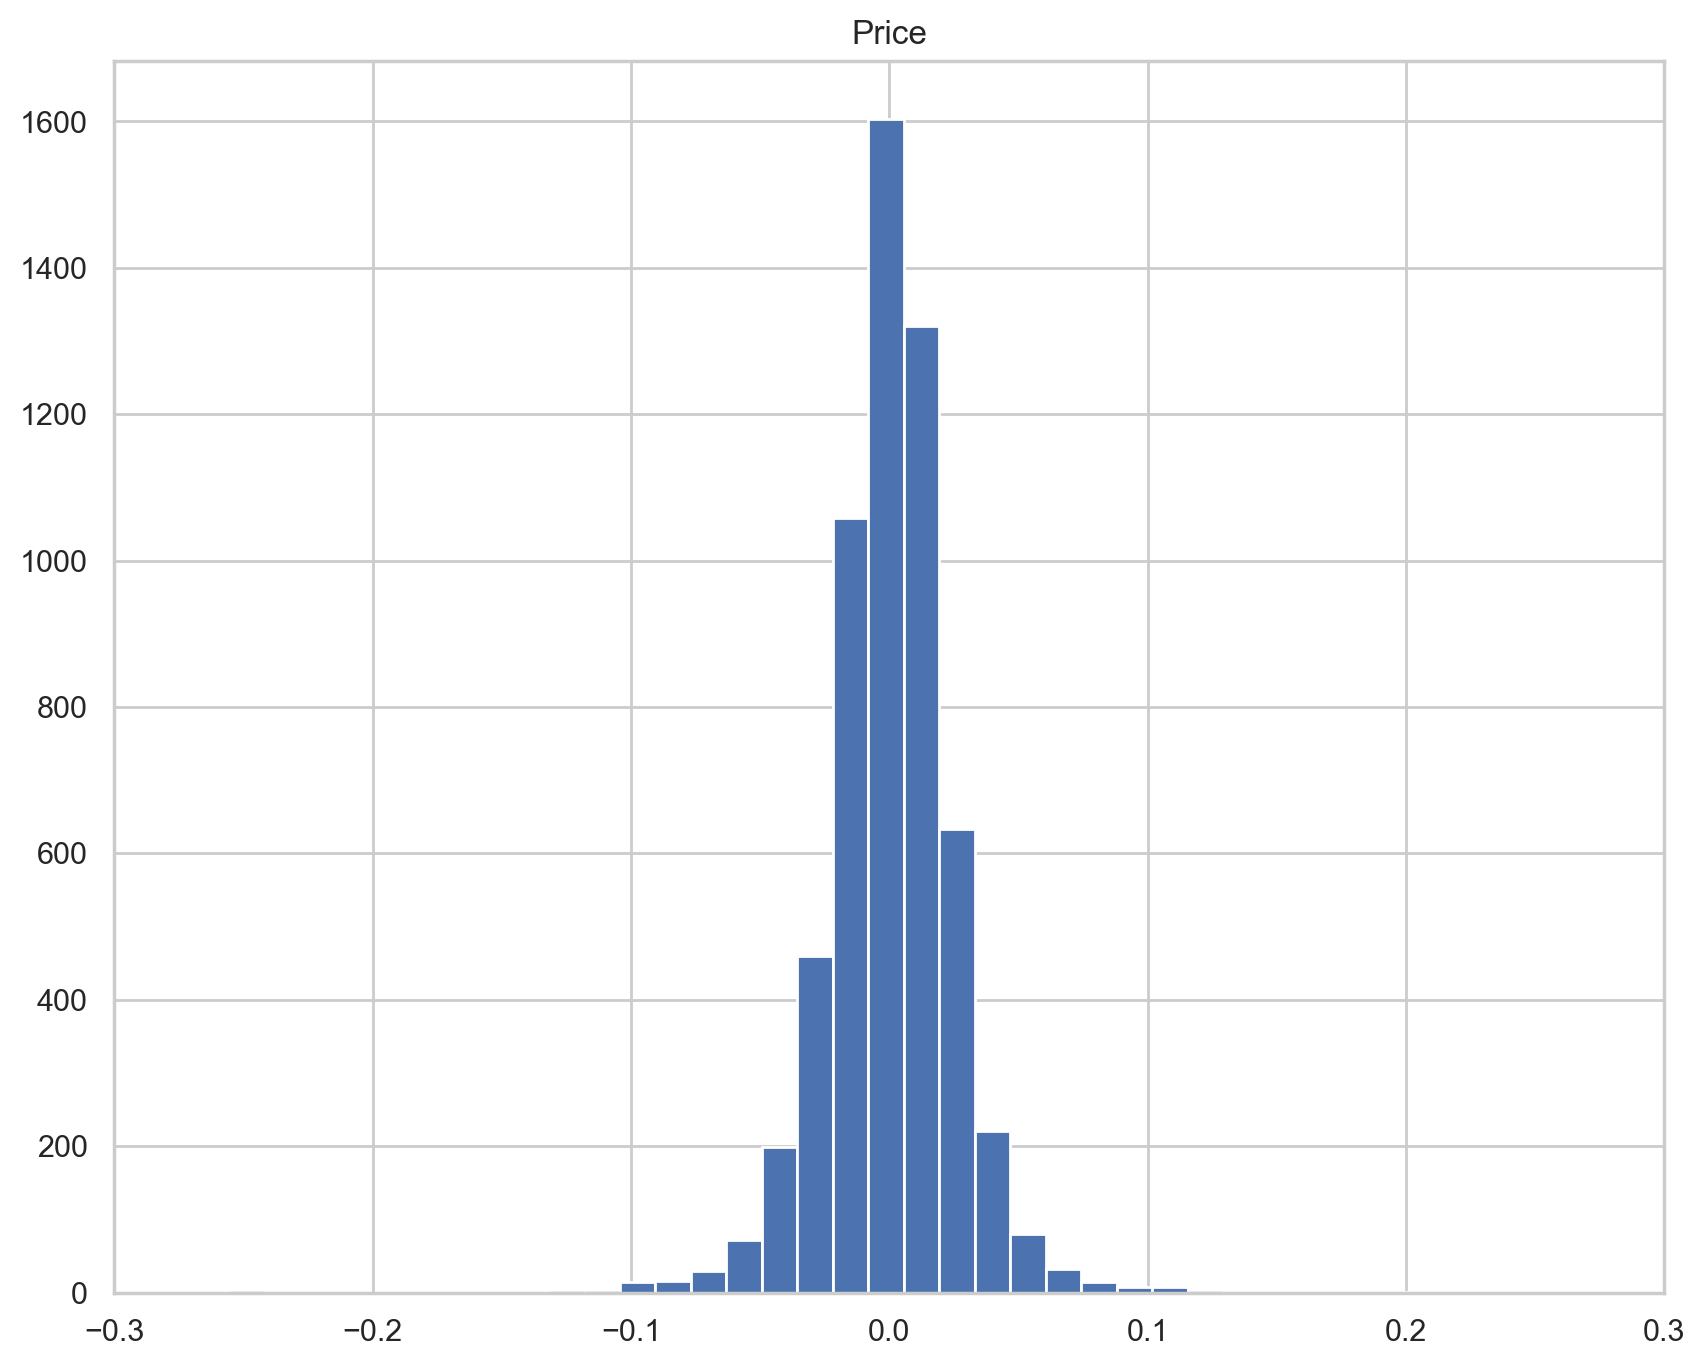

In [19]:
#pct_oil=oil['Price'].pct_change()
pct_change.hist(bins=250)
plt.xlim([-0.3,0.3])

In [20]:
# Adding week, months and year columns to the dataframe
oil['Month'] = oil.index.month
oil['Year'] = oil.index.year

In [21]:
oil

,Price,Month,Year
Date,,,
2001-01-02,27.200001,1,2001
2001-01-03,27.950001,1,2001
2001-01-04,28.200001,1,2001
2001-01-05,28.000000,1,2001
2001-01-08,27.350000,1,2001
...,...,...,...
2024-01-25,77.360001,1,2024
2024-01-26,78.010002,1,2024
2024-01-29,76.779999,1,2024


In [22]:
oil.dtypes

Price    float64
Month      int64
Year       int64
dtype: object

In [23]:
print(oil.groupby('Month')['Price'].mean())

Month
1     61.225708
2     61.798863
3     63.844841
4     64.971011
5     66.164435
6     67.169959
7     67.775155
8     66.616928
9     66.287752
10    65.180474
11    63.693312
12    61.411913
Name: Price, dtype: float64


In [24]:
print(oil.groupby('Year')['Price'].mean())

Year
2001    25.960405
2002    26.150440
2003    30.994400
2004    41.469076
2005    56.704502
2006    66.254560
2007    72.364524
2008    99.751541
2009    62.094088
2010    79.609881
2011    95.114405
2012    94.213520
2013    98.046825
2014    92.906786
2015    48.761349
2016    43.435800
2017    50.853267
2018    64.947450
2019    57.041825
2020    39.344269
2021    68.106032
2022    94.331474
2023    77.592152
2024    73.860952
Name: Price, dtype: float64


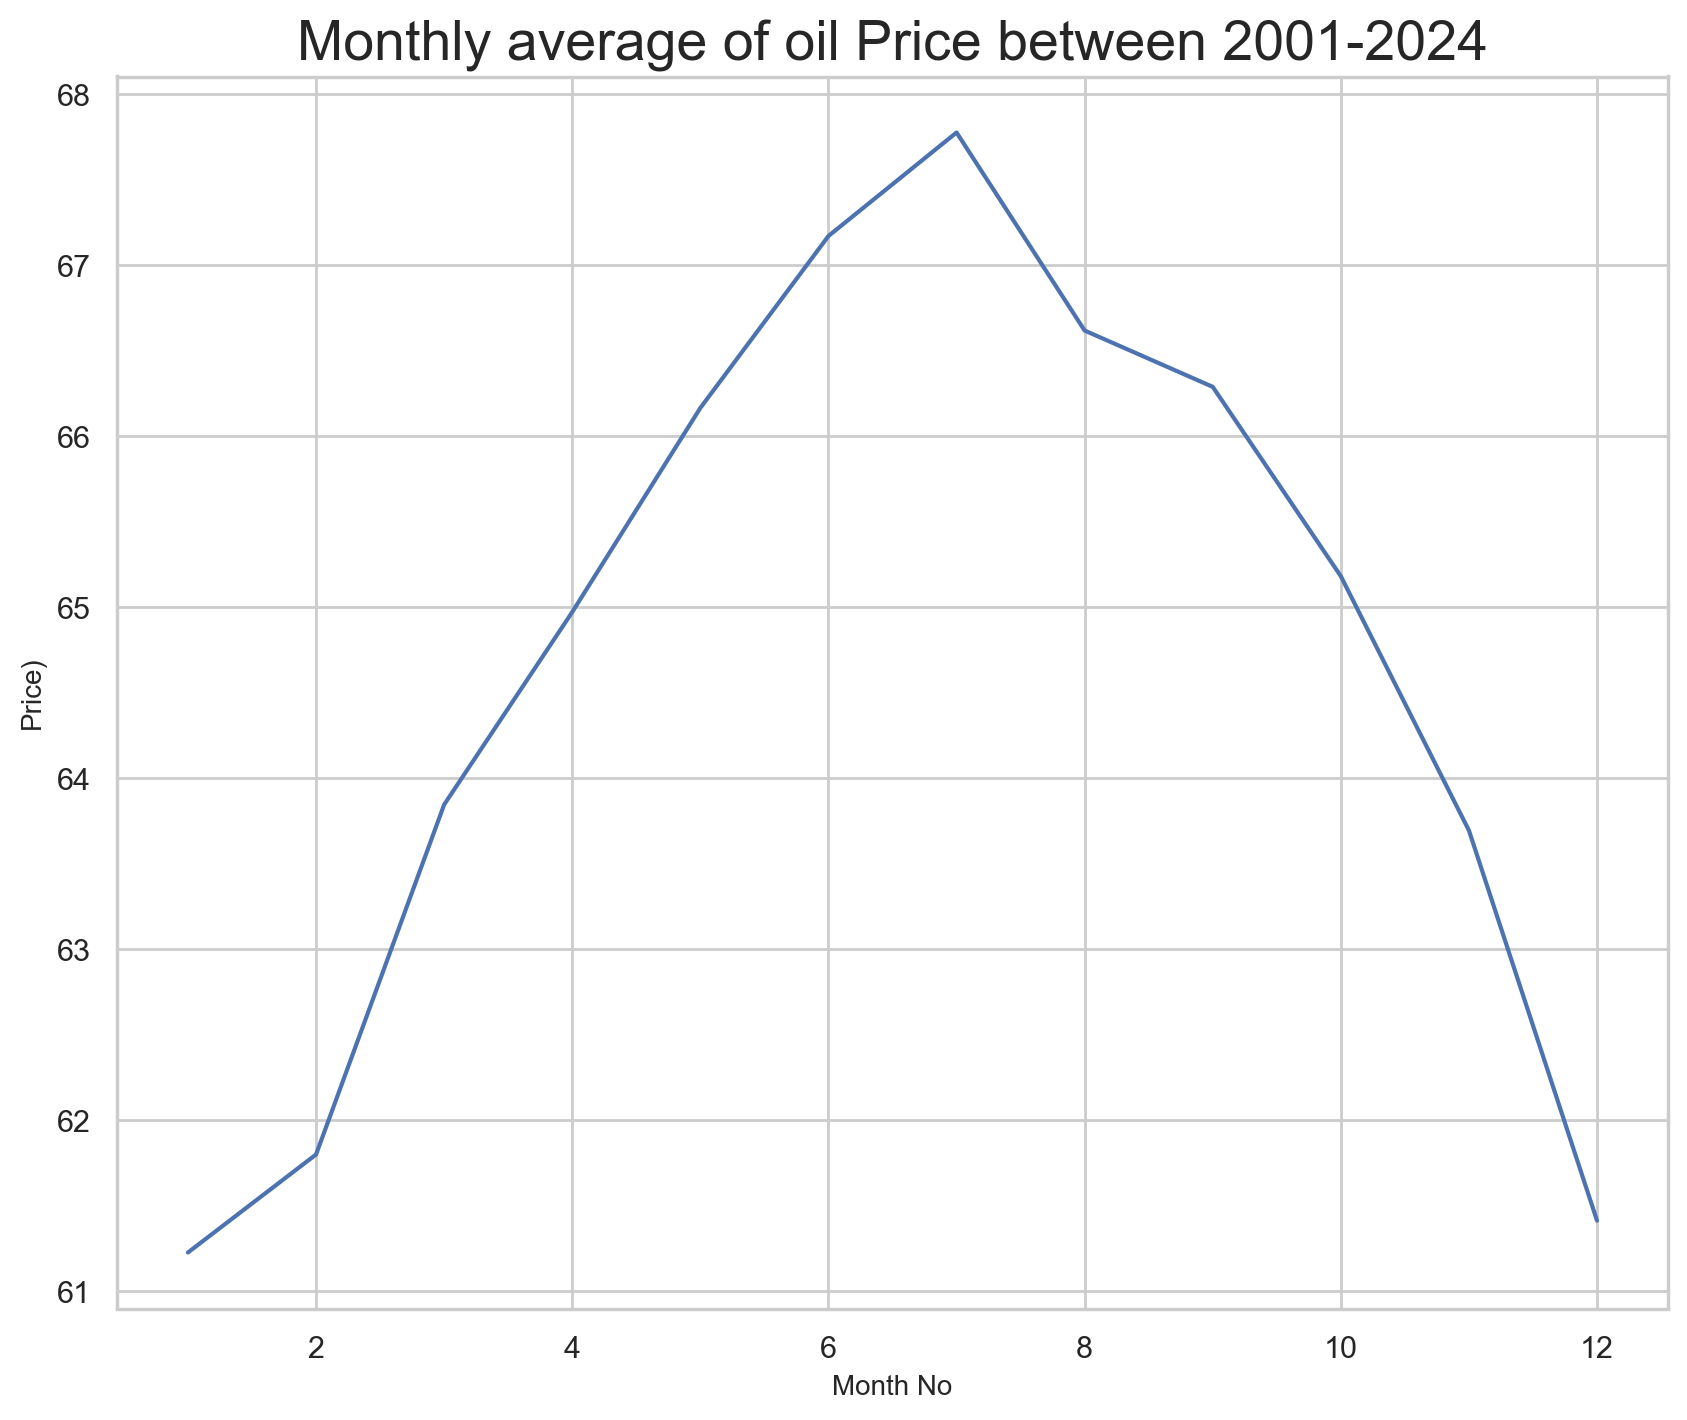

In [25]:
# Grouping by Months and plotting the mean
plt.plot(oil.groupby('Month')['Price'].mean())
plt.title("Monthly average of oil Price between 2001-2024",fontsize=20)
plt.xlabel("Month No", fontsize=10)
plt.ylabel("Price)",fontsize=10)
plt.savefig('monthly_avg.png')

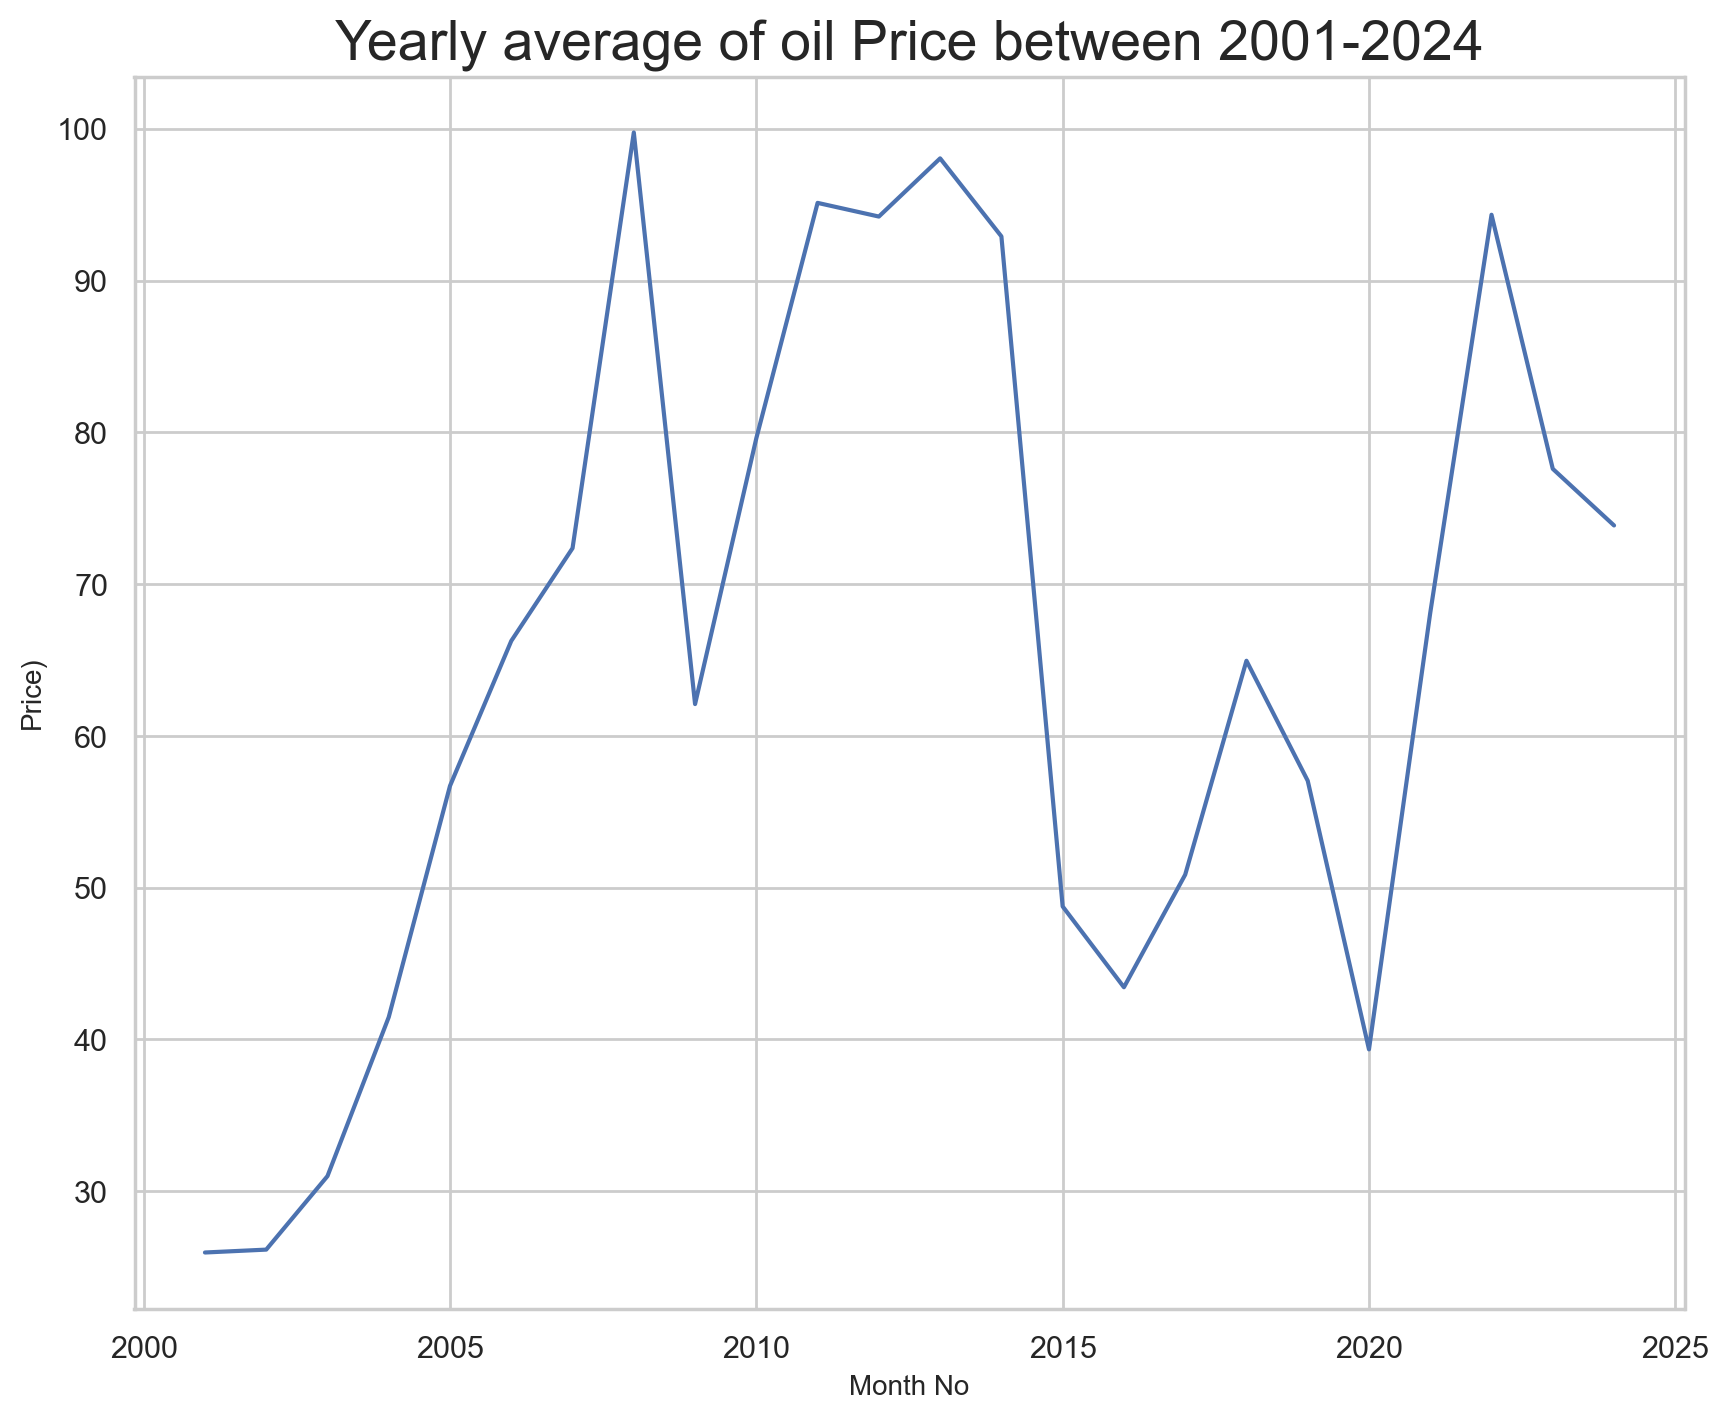

In [26]:
# Grouping by Years and plotting the mean
plt.plot(oil.groupby('Year')['Price'].mean())
plt.title("Yearly average of oil Price between 2001-2024",fontsize=20)
plt.xlabel("Month No", fontsize=10)
plt.ylabel("Price)",fontsize=10)
plt.savefig('Yearly_avg.png')

<AxesSubplot:ylabel='Price'>

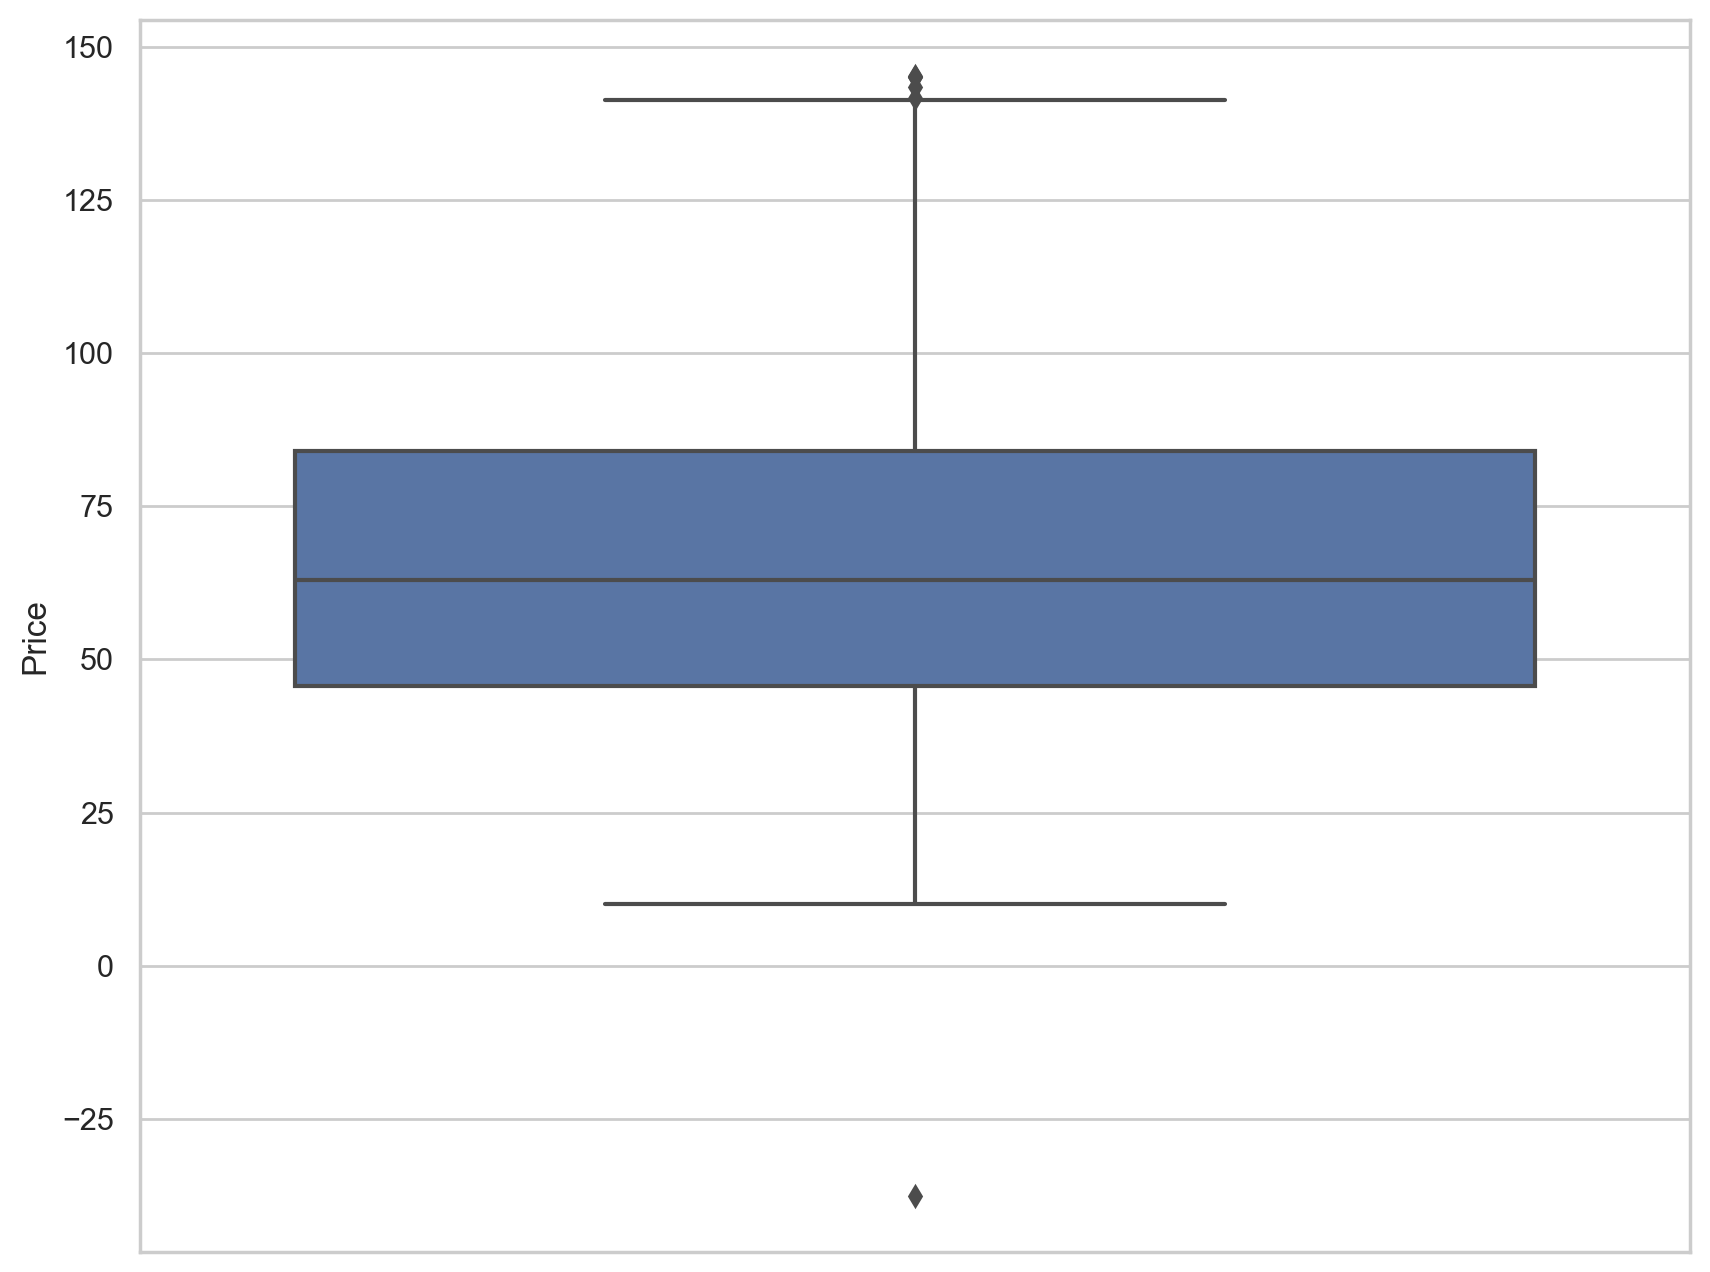

In [27]:
# Boxplot
sns.boxplot(y=oil['Price'])

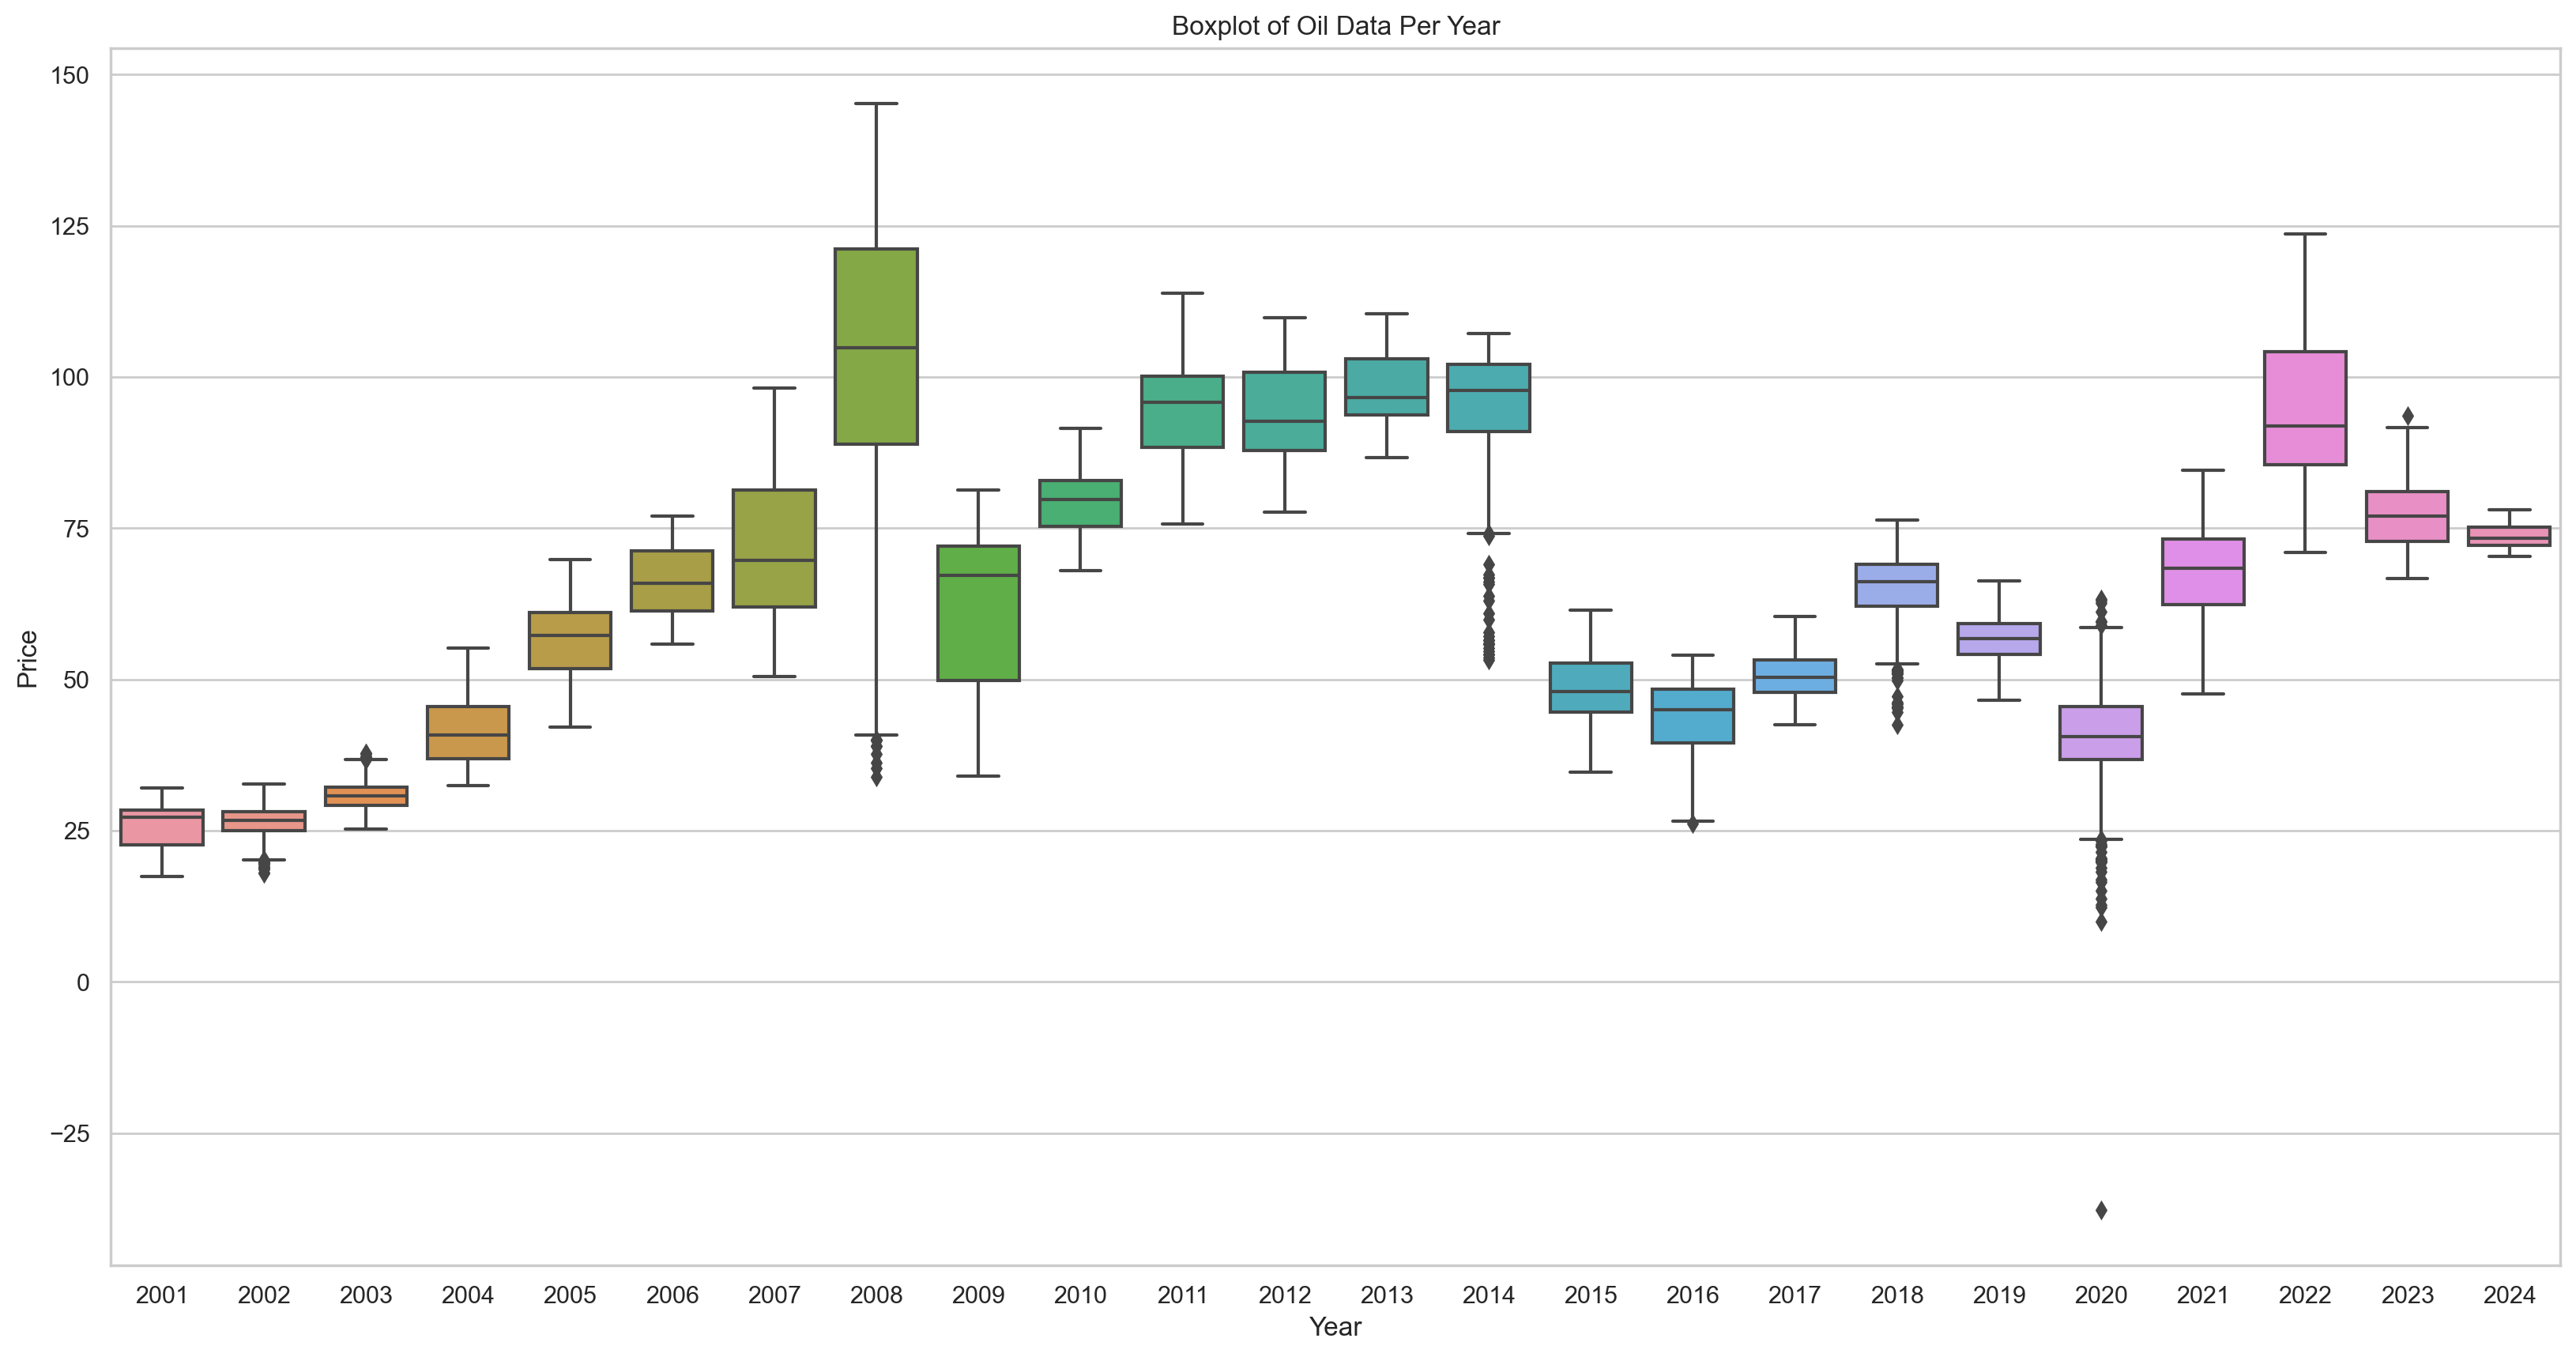

In [28]:
# Boxplot for Crude Price by Year
plt.figure(figsize=(20,10))
sns.boxplot(x='Year',y='Price',data=oil)
plt.title('Boxplot of Oil Data Per Year')
plt.savefig('box_year.png')

In [29]:
# Ad-fuller test to check the stationarity of the signal
result = adfuller(oil['Price'])
print('ADF Statistic : %f' % result[0])
print('p-value : %f' % result[1])
print('Critical Values : ')
for key,value in result[4].items():
    print('\t%s : %.3f' %(key,value))
ans_oil = 'stationary' if result[1] < 0.05 else 'not stationary'

print(ans_oil)

ADF Statistic : -2.784421
p-value : 0.060534
Critical Values : 
	1% : -3.431
	5% : -2.862
	10% : -2.567
not stationary


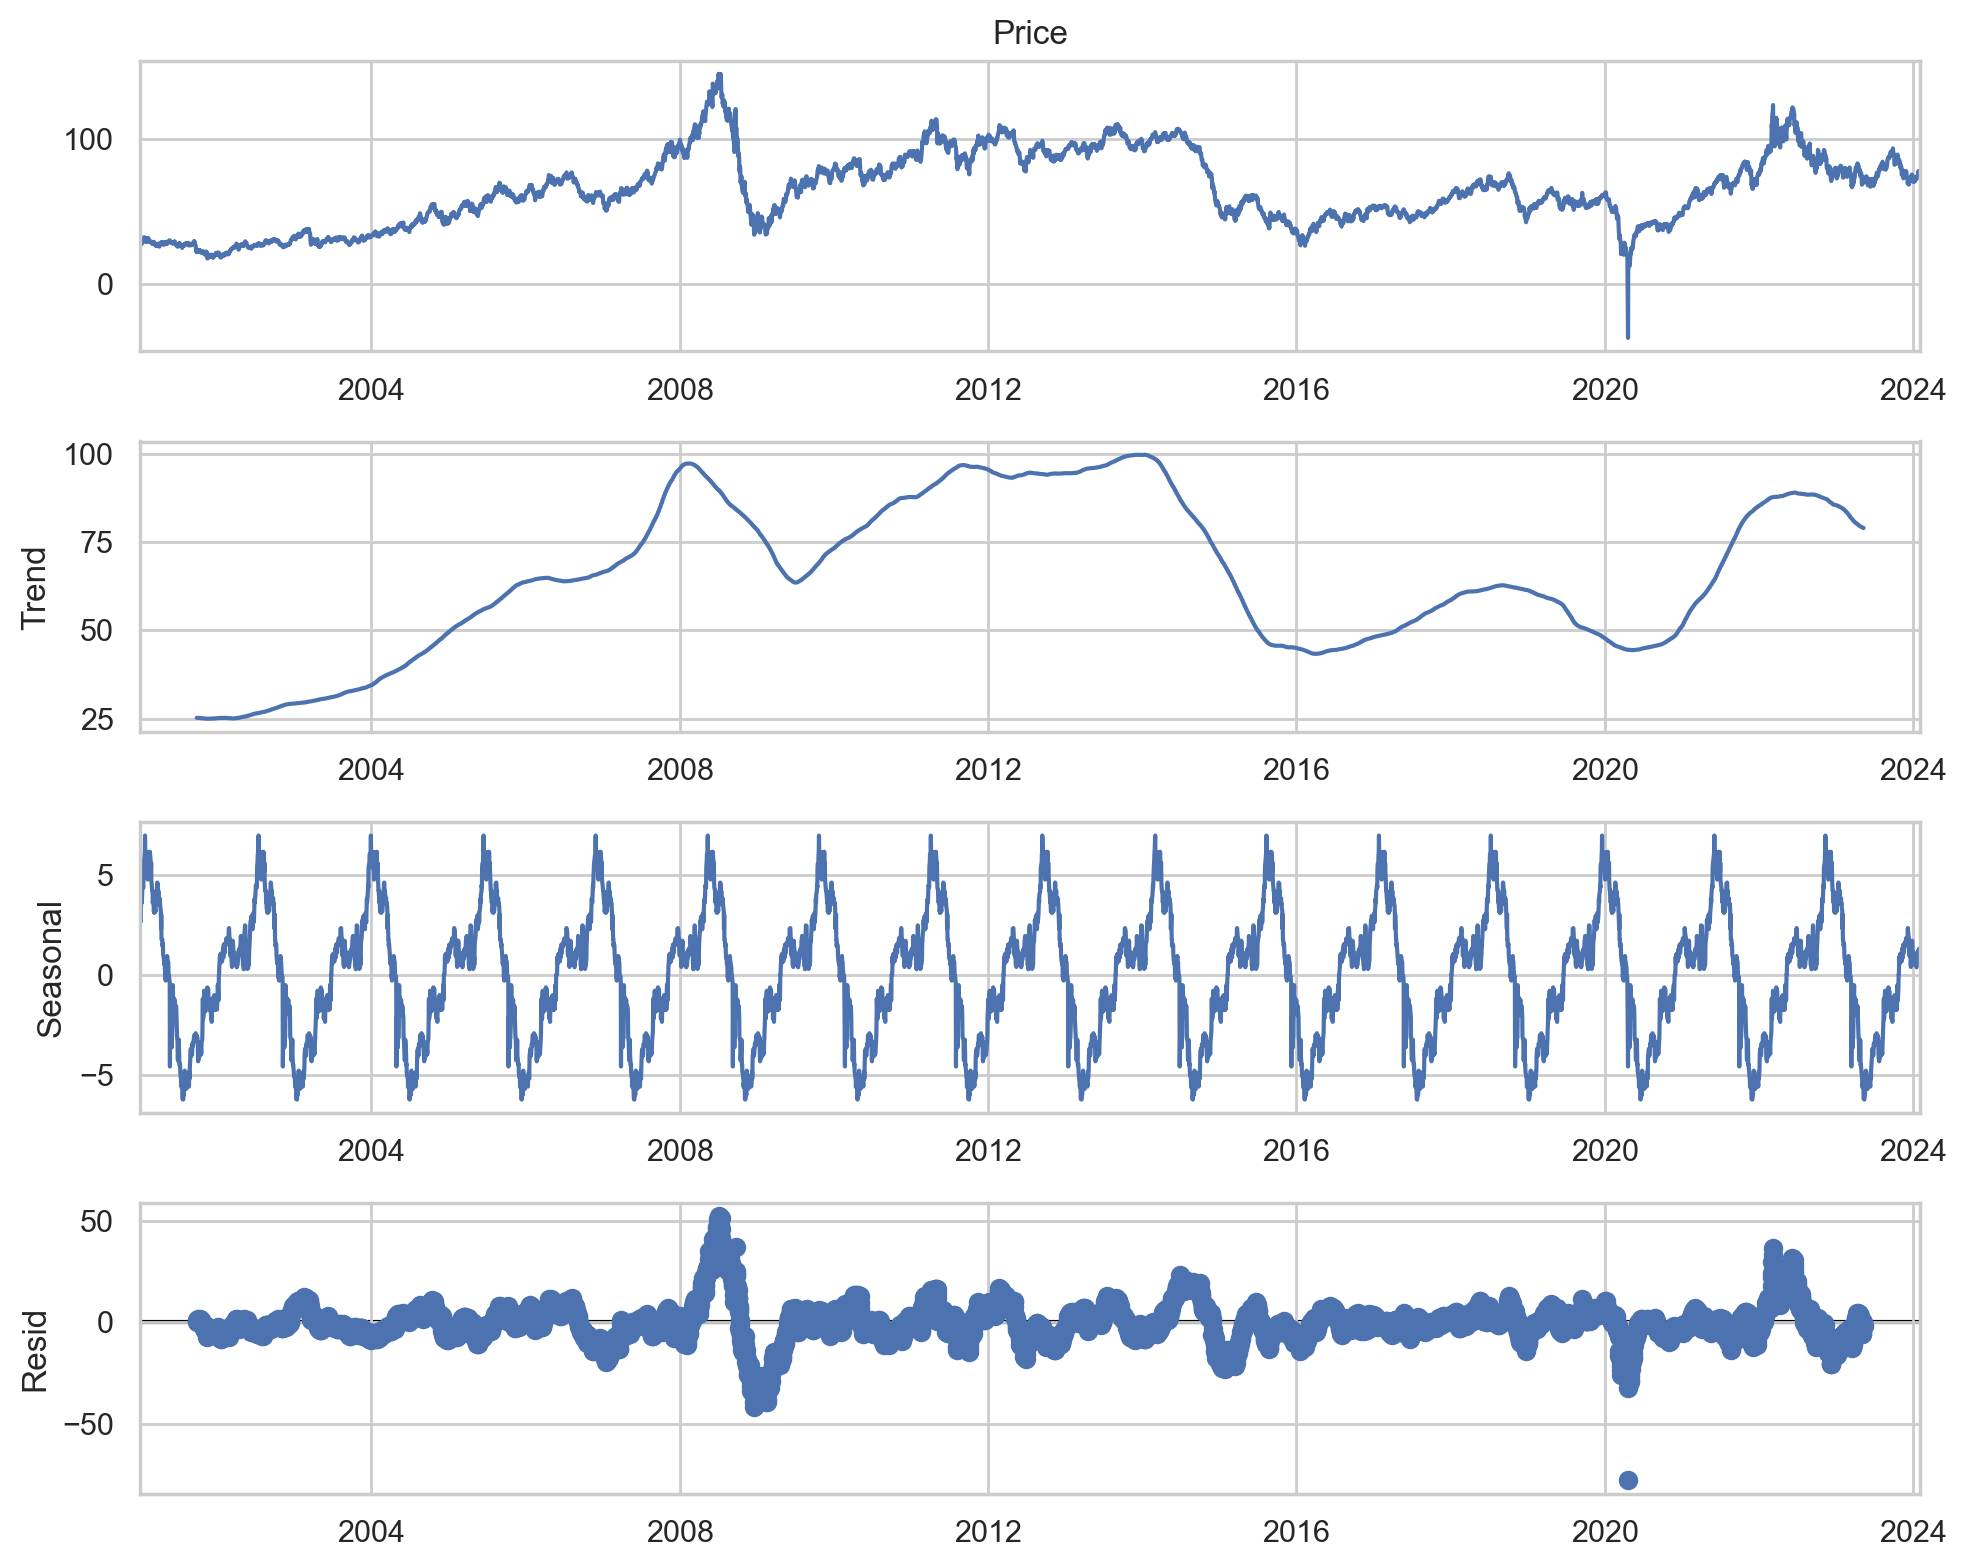

In [30]:
# Seasonal decomposition plot
sea_decom=seasonal_decompose(oil['Price'],model='additive',period=365)
sea_decom.plot()
plt.savefig('Seasonal_Decompose.png')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


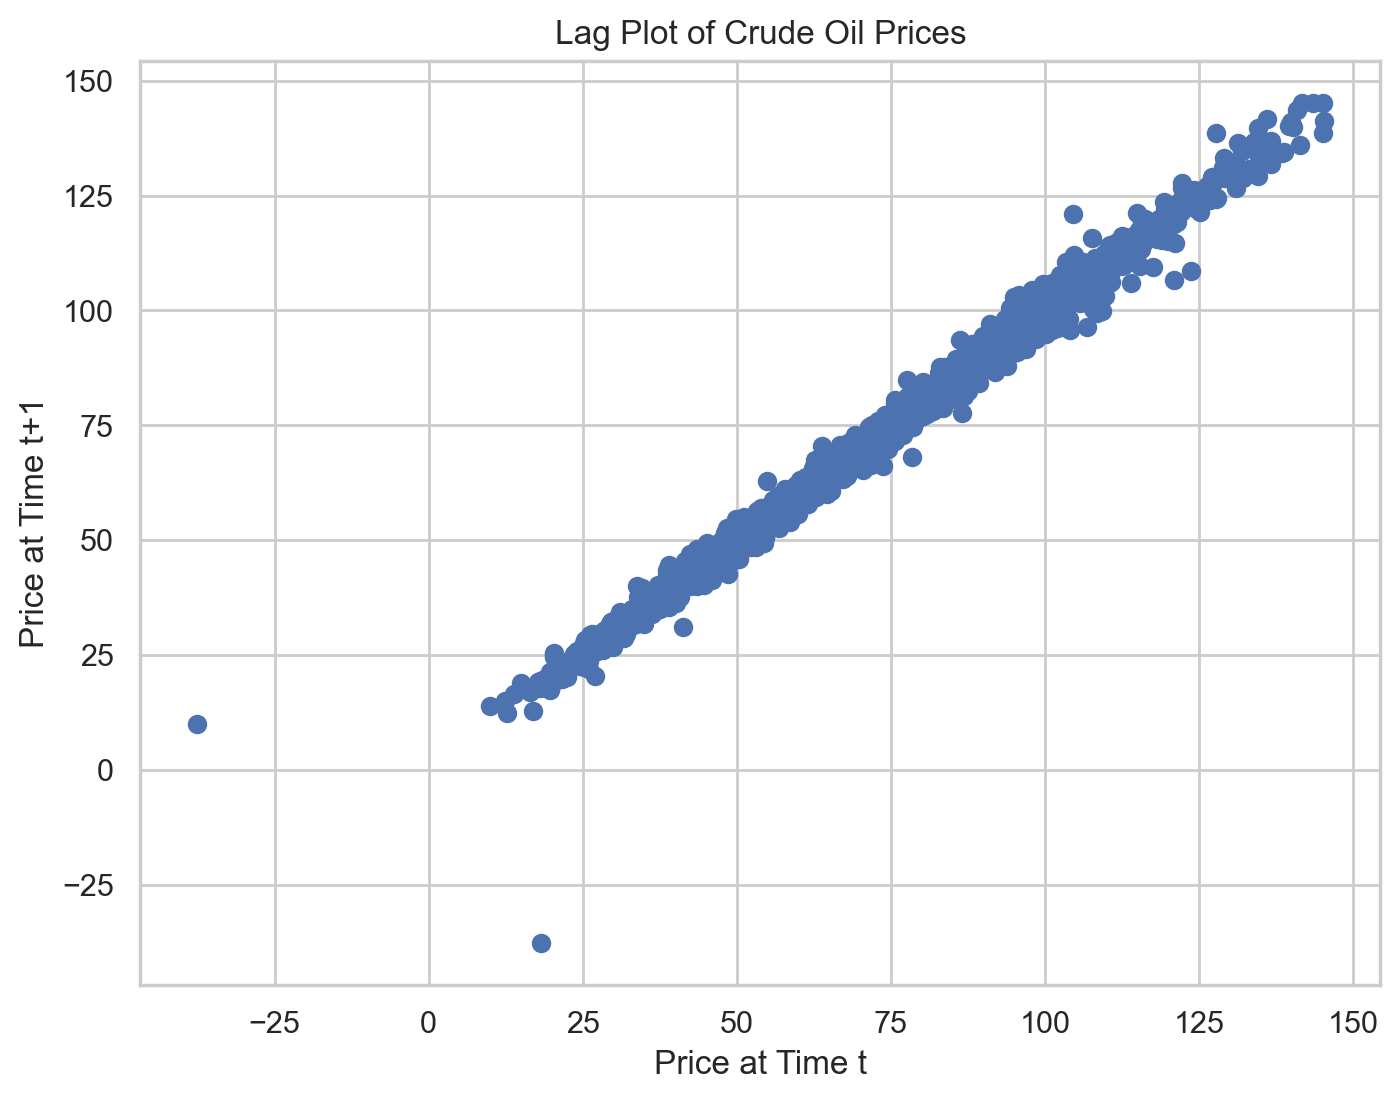

In [31]:
# lag plot
plt.figure(figsize=(8, 6))
lag_plot(oil['Price'], lag=1)
plt.title('Lag Plot of Crude Oil Prices')
plt.xlabel('Price at Time t')
plt.ylabel('Price at Time t+1')
plt.grid(True)
plt.savefig('Lagplot.png')

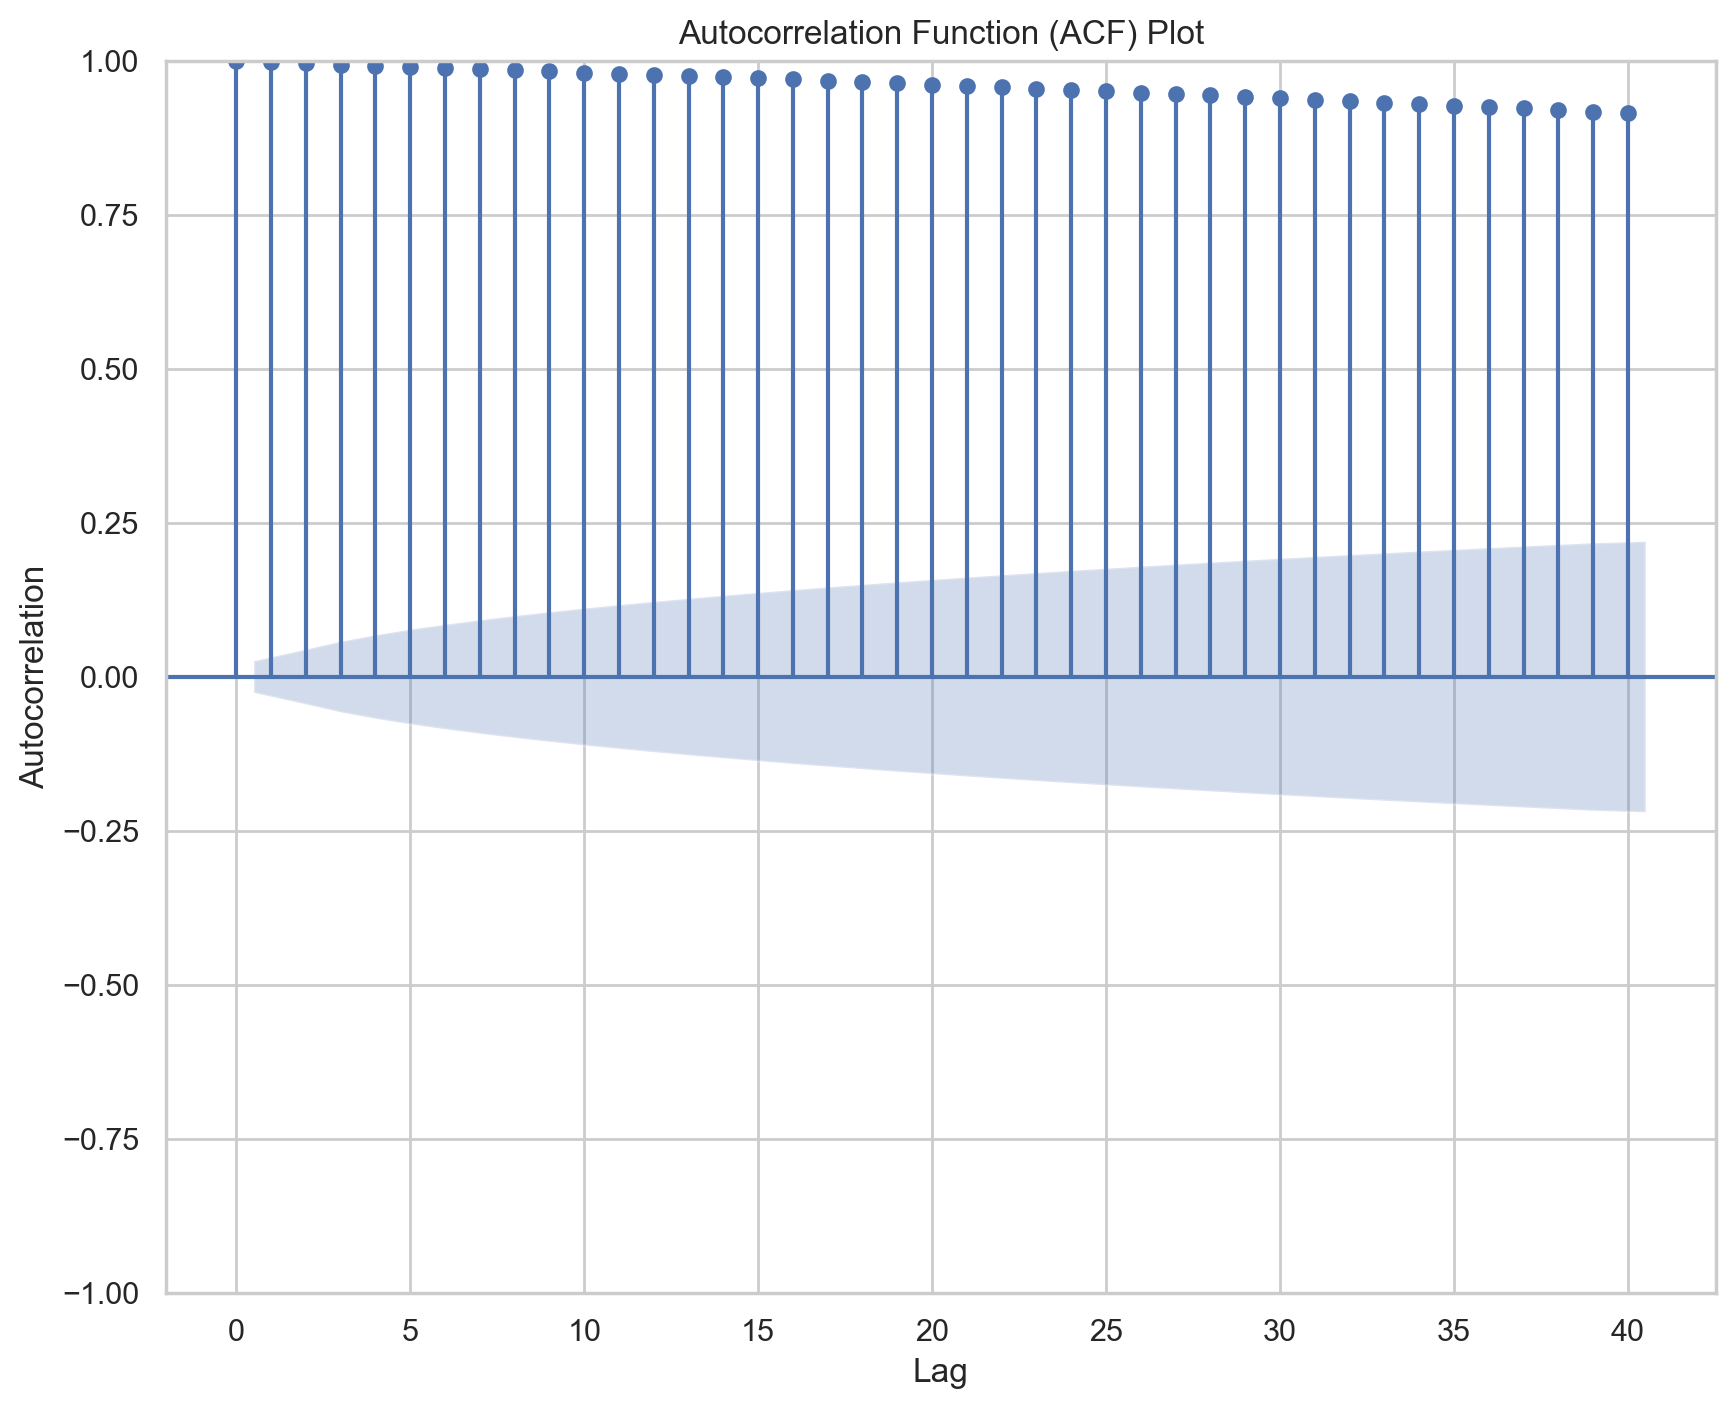

In [32]:
# Plot ACF to determine AR and MA process orders
plot_acf(oil['Price'], lags=40)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.savefig('acf_plot.png')

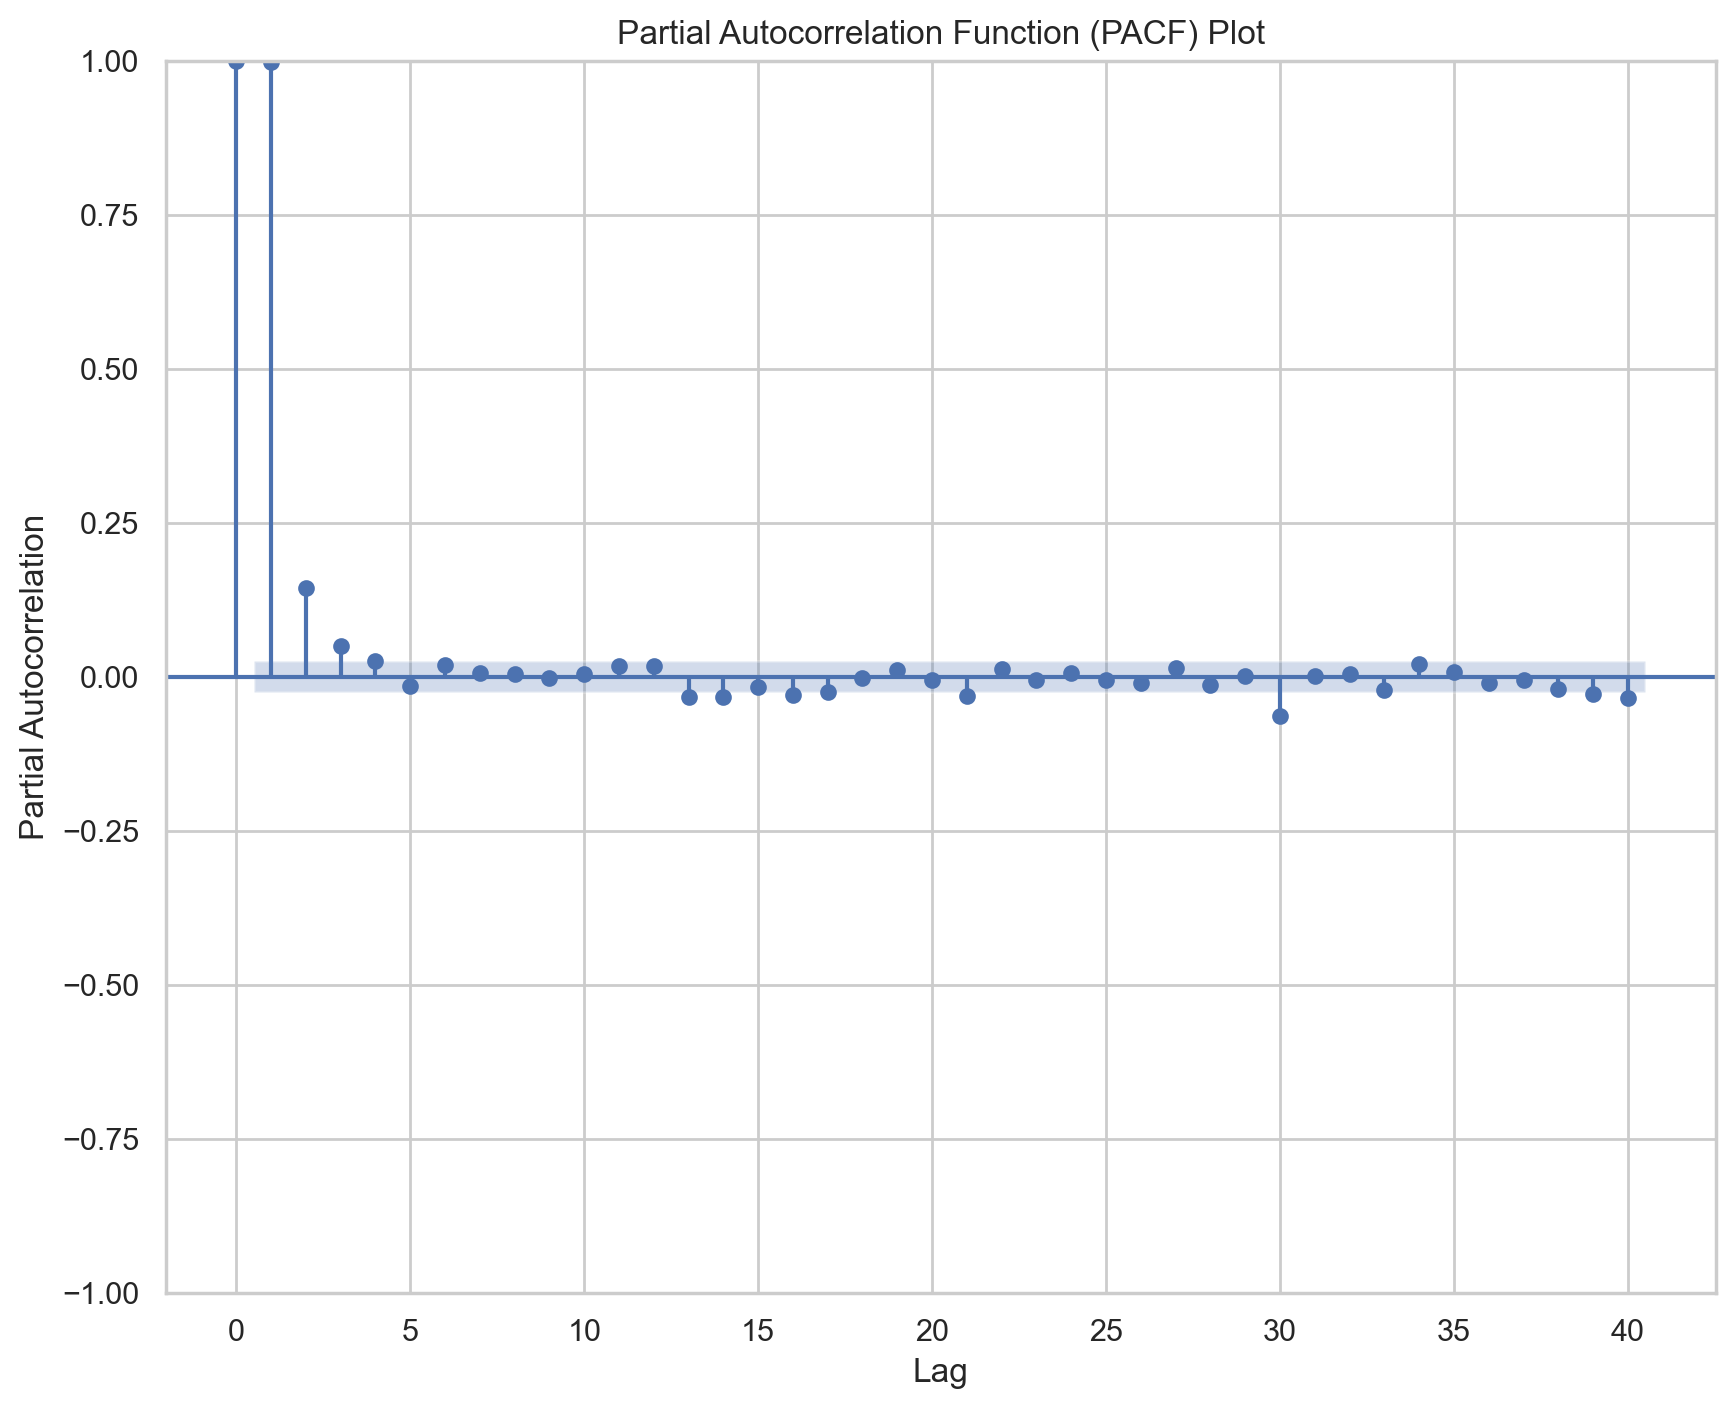

In [33]:
# Plot PACF to determine AR and MA process orders
plot_pacf(oil['Price'], lags=40)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.savefig('pacf_plot.png')

In [34]:
OIL=oil
OIL

,Price,Month,Year
Date,,,
2001-01-02,27.200001,1,2001
2001-01-03,27.950001,1,2001
2001-01-04,28.200001,1,2001
2001-01-05,28.000000,1,2001
2001-01-08,27.350000,1,2001
...,...,...,...
2024-01-25,77.360001,1,2024
2024-01-26,78.010002,1,2024
2024-01-29,76.779999,1,2024


In [35]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
OIL = sc.fit_transform(OIL)
OIL

array([[0.35441725, 0.        , 0.        ],
       [0.35851741, 0.        , 0.        ],
       [0.35988412, 0.        , 0.        ],
       ...,
       [0.6254647 , 0.        , 1.        ],
       [0.63115025, 0.        , 1.        ],
       [0.62038051, 0.        , 1.        ]])

In [36]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install tensorflow

  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)
  Using cached tensorflow_intel-2.15.0-cp39-cp39-win_amd64.whl (300.8 MB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Using cached grpcio-1.62.0-cp39-cp39-win_amd64.whl (3.8 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached ml_dtypes-0.2.0-cp39-cp39-win_amd64.whl (938 kB)
  Using cached google_auth-2.28.1-py2.py3-none-any.whl (186 kB)
  Using cached google_auth_oauthlib-1.2.0-py2.py3-none-any.whl (24 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl (9.3 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successf

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [40]:
data = oil
data

,Price,Month,Year
Date,,,
2001-01-02,27.200001,1,2001
2001-01-03,27.950001,1,2001
2001-01-04,28.200001,1,2001
2001-01-05,28.000000,1,2001
2001-01-08,27.350000,1,2001
...,...,...,...
2024-01-25,77.360001,1,2024
2024-01-26,78.010002,1,2024
2024-01-29,76.779999,1,2024


In [41]:
prices = data['Price'].values.reshape(-1, 1)

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [55]:
def create_seq(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [56]:
seq_length = 20

In [57]:
x, y = create_seq(prices_scaled, seq_length)

In [58]:
# Split data into train and test sets
split_index = int(0.7 * len(x))
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [59]:
split_index

4043

In [60]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [61]:
# Train the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
history=model.fit(x_train, y_train, epochs=20, batch_size=32,validation_data=(x_test, y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
127/127 [==============================] - 6s 23ms/step - loss: 0.0050 - val_loss: 0.0027 - lr: 0.0010
Epoch 2/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0074 - lr: 0.0010
Epoch 3/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0039 - val_loss: 0.0118 - lr: 0.0010
Epoch 4/20
127/127 [==============================] - 2s 16ms/step - loss: 0.0044 - val_loss: 0.0146 - lr: 0.0010
Epoch 5/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0042 - val_loss: 0.0156 - lr: 0.0010
Epoch 6/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0037 - val_loss: 0.0142 - lr: 0.0010
Epoch 7/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0031 - val_loss: 0.0119 - lr: 0.0010
Epoch 8/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0025 - val_loss: 0.0095 - lr: 0.0010
Epoch 9/20
127/127 [==============================] - 2s 15ms/step - loss: 0.0021 - val_

In [62]:
train_loss = model.evaluate(x_train, y_train, verbose=1)
test_loss = model.evaluate(x_test, y_test, verbose=1)

55/55 [==============================] - 0s 5ms/step - loss: 5.2073e-04


In [63]:
print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.0006892230594530702
Test Loss: 0.0005207285867072642


In [64]:
train_predictions = scaler.inverse_transform(model.predict(x_train))
test_predictions = scaler.inverse_transform(model.predict(x_test))

55/55 [==============================] - 0s 5ms/step
